# Spaceship Titanic Preprocessing

**Description:**

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!
___

# 1. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style='darkgrid', font_scale=2)
import warnings
warnings.filterwarnings('ignore')
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler, PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

In [2]:
COMPARING_MODELS = False
DEBUG = False
VISUALIZING = True

# 2. Loading Data

In [3]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

df_train.head() if VISUALIZING else None

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


**Columns Description**
* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

# 3. Exploring/Viewing Data

In [4]:
if VISUALIZING:
    r1,c1 = df_train.shape
    print('The training data has {} rows and {} columns'.format(r1,c1))
    r2,c2 = df_test.shape
    print('The validation data has {} rows and {} columns'.format(r2,c2))

The training data has 8693 rows and 14 columns
The validation data has 4277 rows and 13 columns


In [5]:
df_train.info() if VISUALIZING else None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
df_train.describe() if VISUALIZING else None

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [7]:
df_test.describe() if VISUALIZING else None

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


## 3.B Fixing Missing Values 

In [8]:
if VISUALIZING:
    print('MISSING VALUES IN TRAINING DATASET:')
    print(df_train.isna().sum().nlargest(c1))
    print('')
    print('MISSING VALUES IN VALIDATION DATASET:')
    print(df_test.isna().sum().nlargest(c2))

MISSING VALUES IN TRAINING DATASET:
CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
Spa             183
FoodCourt       183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64

MISSING VALUES IN VALIDATION DATASET:
FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
VIP              93
CryoSleep        93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64


In [9]:
df_train.set_index('PassengerId',inplace=True)
df_test.set_index('PassengerId',inplace=True)

## 3.C Null Replacement 

In [10]:
df_train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = df_train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].fillna(0)
df_test[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = df_test[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].fillna(0)

df_train['Age'] =df_train['Age'].fillna(df_train['Age'].median())
df_test['Age'] =df_test['Age'].fillna(df_test['Age'].median())

df_train['VIP'] =df_train['VIP'].fillna(False)
df_test['VIP'] =df_test['VIP'].fillna(False)

df_train['HomePlanet'] =df_train['HomePlanet'].fillna('Mars')
df_test['HomePlanet'] =df_test['HomePlanet'].fillna('Mars')

df_train['Destination']=df_train['Destination'].fillna("PSO J318.5-22")
df_test['Destination']=df_test['Destination'].fillna("PSO J318.5-22")

df_train['CryoSleep'] =df_train['CryoSleep'].fillna(False)
df_test['CryoSleep'] =df_test['CryoSleep'].fillna(False)

df_train['Cabin'] =df_train['Cabin'].fillna('T/0/P')
df_test['Cabin'] =df_test['Cabin'].fillna('T/0/P')

# 4. Exploration and Visualization 

<Axes: >

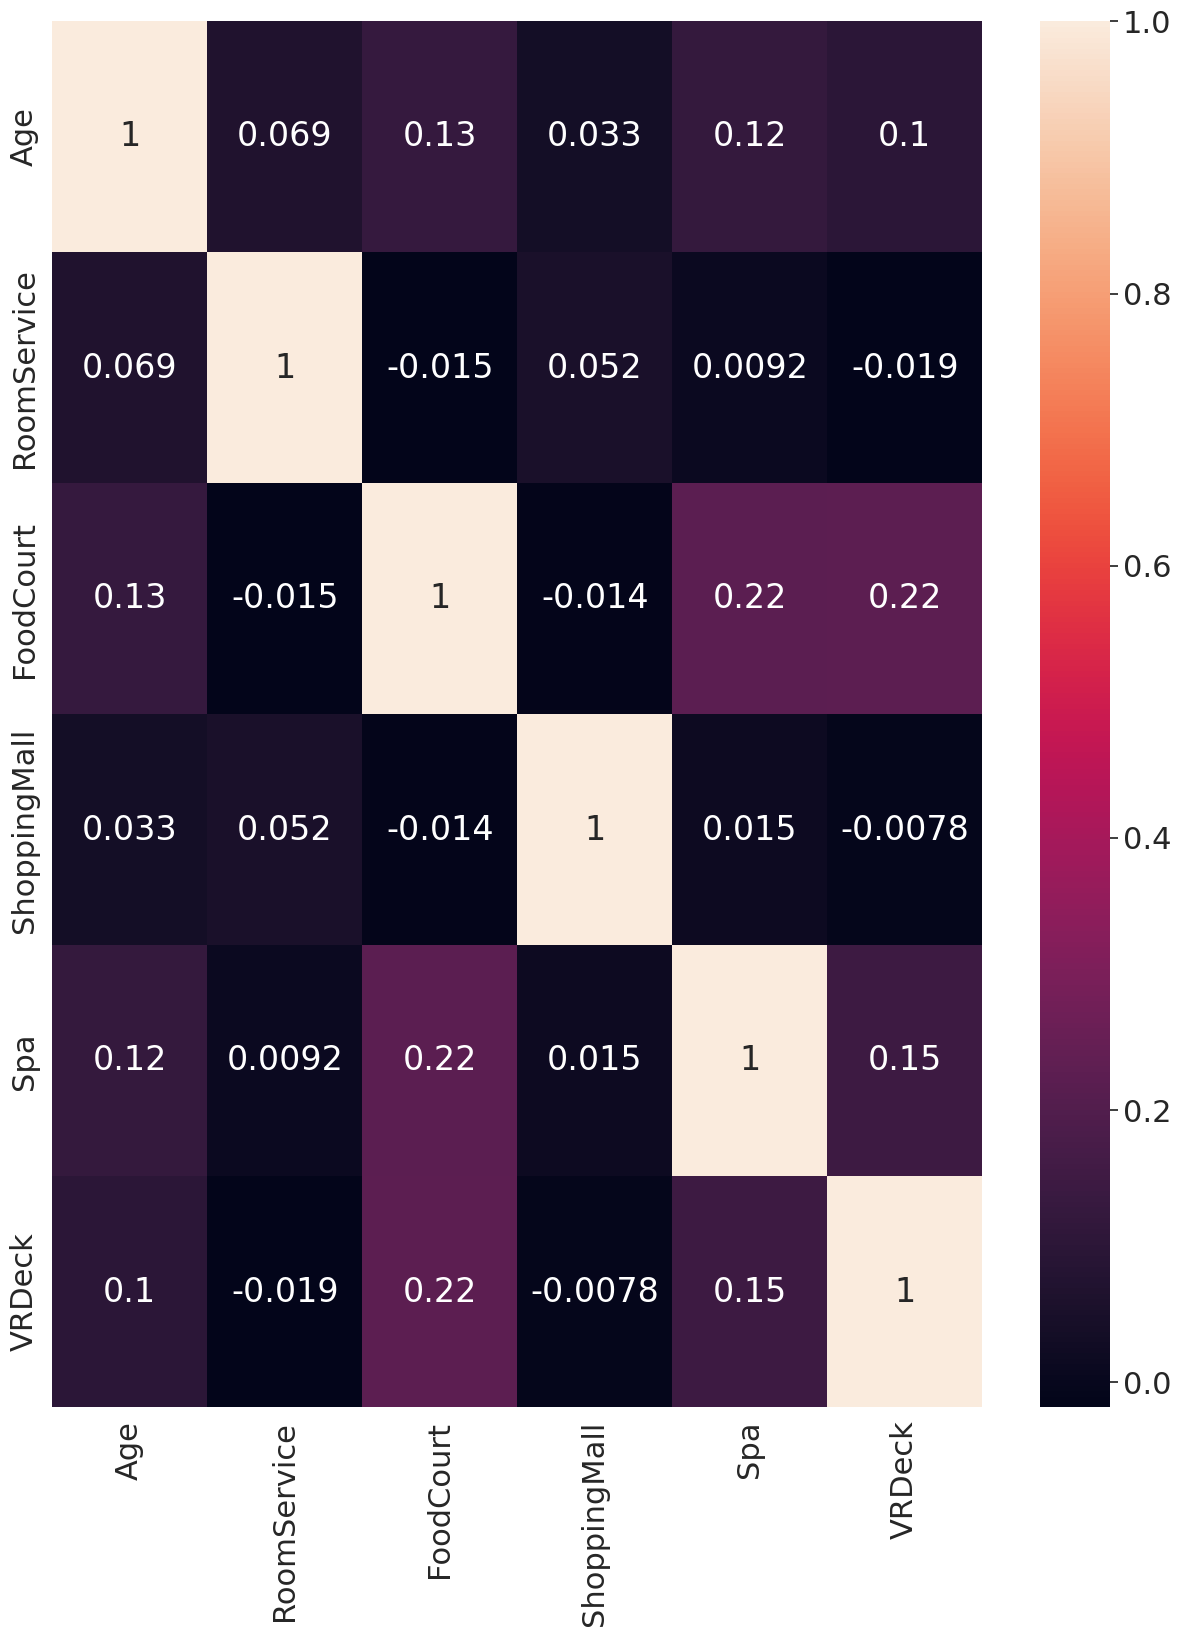

In [11]:
plt.figure(figsize=(15,18)) if VISUALIZING else None
sns.heatmap(df_train.select_dtypes("number").corr(), annot=True) if VISUALIZING else None

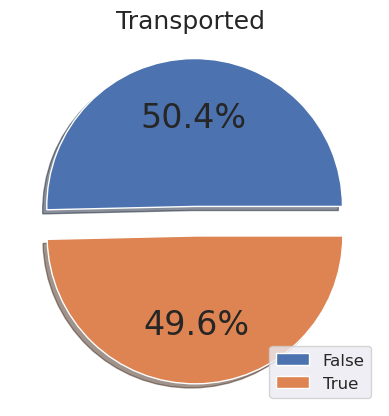

In [12]:
plt.pie(df_train.Transported.value_counts(), shadow=True, explode=[.1,.1], autopct='%.1f%%') if VISUALIZING else None
plt.title('Transported ', size=18) if VISUALIZING else None
plt.legend(['False', 'True'], loc='best', fontsize=12) if VISUALIZING else None
plt.show() if VISUALIZING else None

<Axes: xlabel='Transported', ylabel='count'>

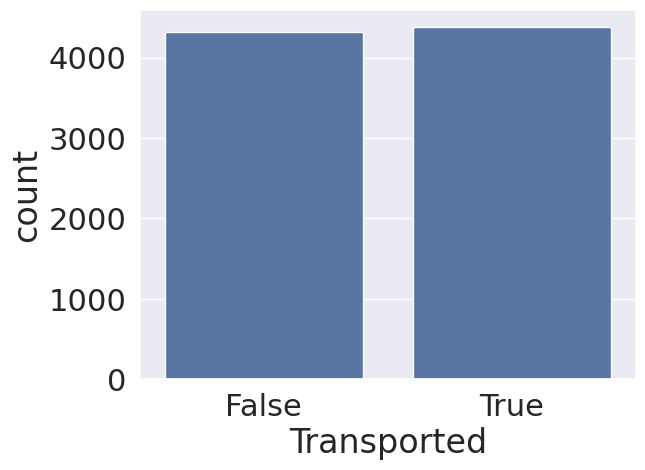

In [13]:
sns.countplot(df_train, x="Transported") if VISUALIZING else None

<Axes: xlabel='HomePlanet', ylabel='count'>

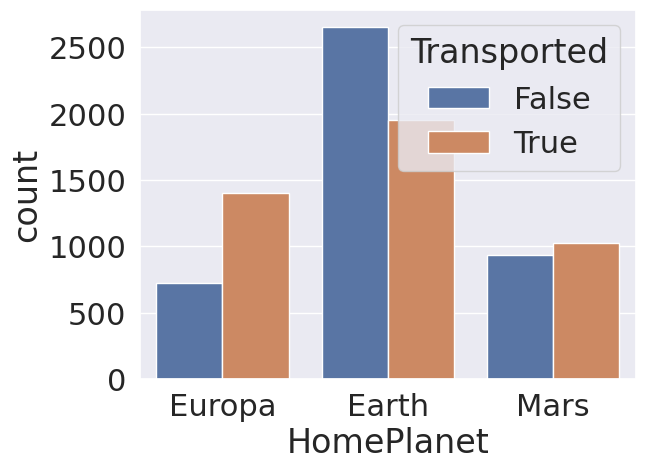

In [14]:
sns.countplot(df_train, x="HomePlanet", hue="Transported") if VISUALIZING else None

<Axes: xlabel='VIP', ylabel='count'>

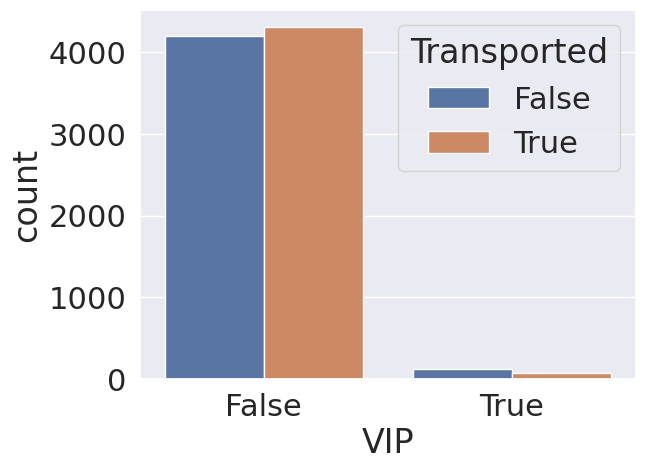

In [15]:
sns.countplot(df_train, x="VIP", hue="Transported") if VISUALIZING else None

<Axes: xlabel='CryoSleep', ylabel='count'>

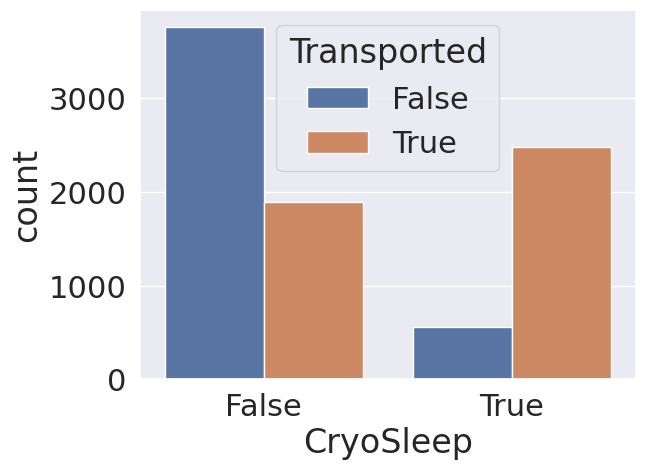

In [16]:
sns.countplot(df_train, x="CryoSleep", hue="Transported") if VISUALIZING else None

([0, 1, 2],
 [Text(0, 0, 'TRAPPIST-1e'),
  Text(1, 0, 'PSO J318.5-22'),
  Text(2, 0, '55 Cancri e')])

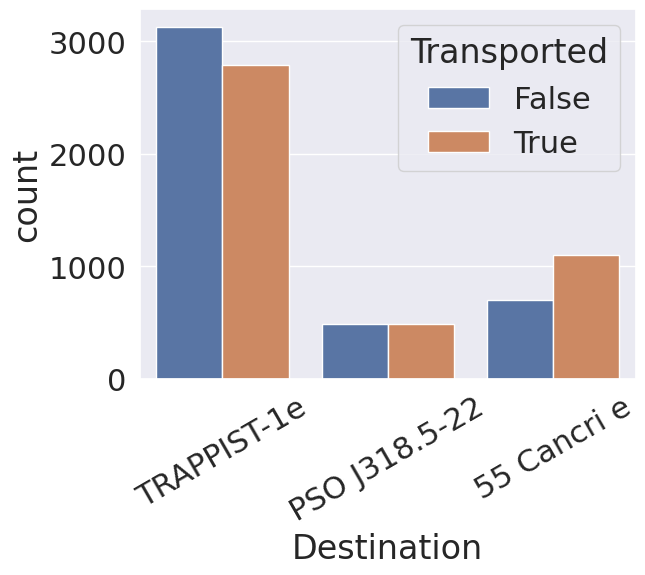

In [17]:
sns.countplot(df_train, x="Destination", hue="Transported") if VISUALIZING else None
plt.xticks(rotation=30) if VISUALIZING else None

<Axes: xlabel='Transported', ylabel='Age'>

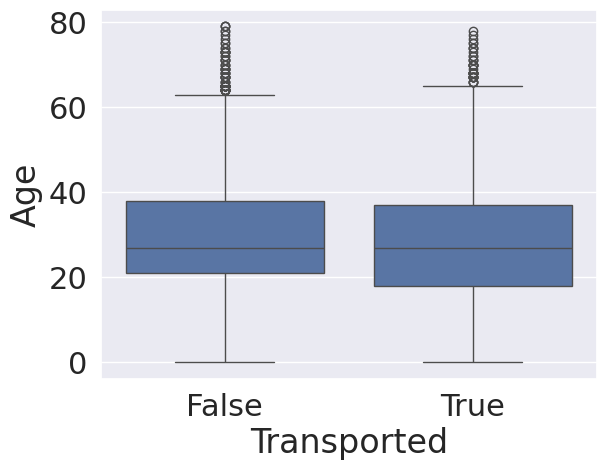

In [18]:
sns.boxplot(df_train, y="Age", x="Transported") if VISUALIZING else None # Age will be divided into groups later

## 4.B Splitting Cabin Column

In [19]:
# Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
df_train[['Deck', 'Cabin_Num', 'Side']] = df_train.Cabin.str.split('/',expand=True)
df_test[['Deck', 'Cabin_Num', 'Side']] = df_test.Cabin.str.split('/',expand=True)

df_train['Cabin_Num'] = pd.to_numeric(df_train['Cabin_Num'], downcast='integer')
df_test['Cabin_Num'] = pd.to_numeric(df_test['Cabin_Num'], downcast='integer')

df_train['Side'] = df_train['Side'].map({'P':0,'S':1})
df_test['Side'] = df_test['Side'].map({'P':0,'S':1})

<Axes: xlabel='count', ylabel='Deck'>

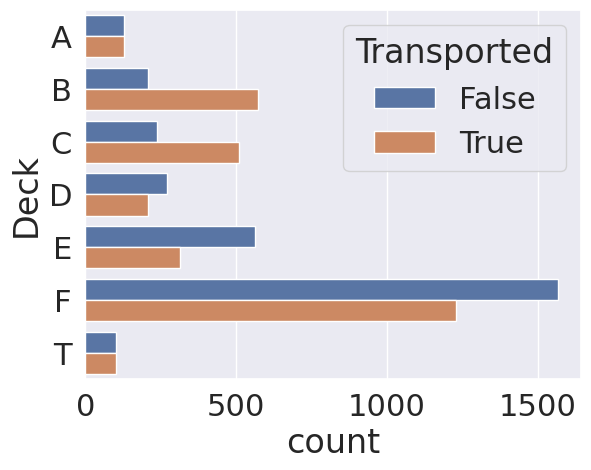

In [20]:
sns.countplot(df_train, y="Deck", hue="Transported", order=["A", "B", "C", "D", "E", "F", "T"]) if VISUALIZING else None

<Axes: xlabel='Cabin_Num', ylabel='Count'>

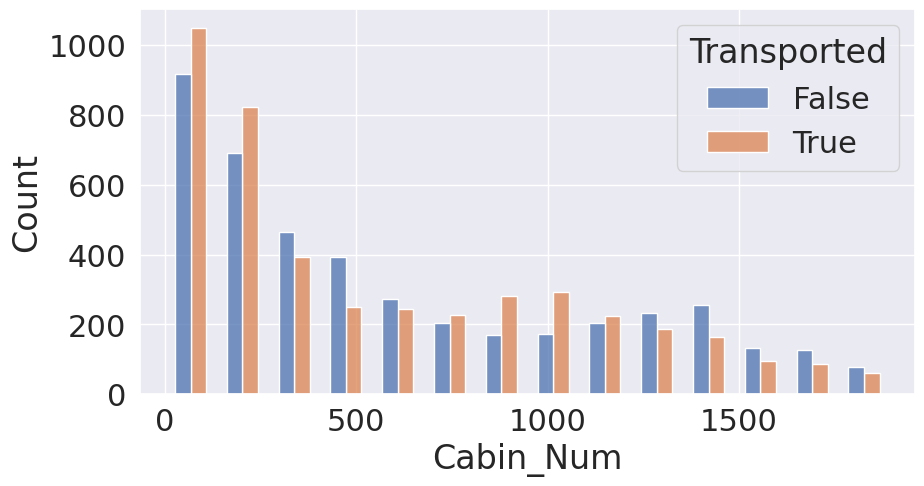

In [21]:
plt.figure(figsize=(10,5)) if VISUALIZING else None
sns.histplot(df_train, x='Cabin_Num', hue='Transported', bins=14, multiple="dodge", shrink=0.6) if VISUALIZING else None

<Axes: xlabel='Side', ylabel='count'>

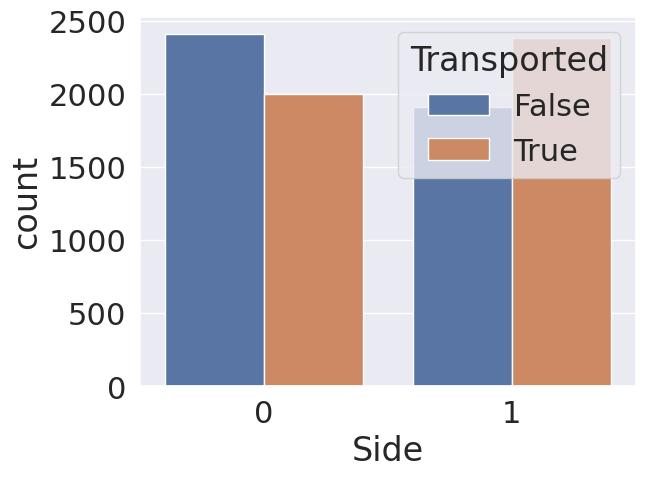

In [22]:
sns.countplot(df_train, x="Side", hue="Transported") if VISUALIZING else None

<Axes: xlabel='Side', ylabel='count'>

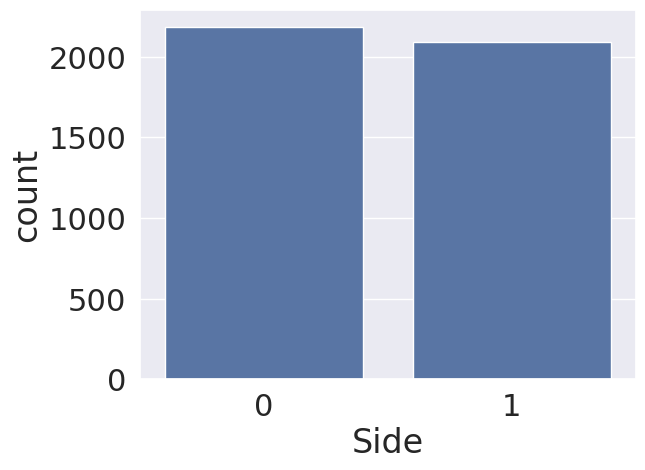

In [23]:
sns.countplot(df_test, x="Side") if VISUALIZING else None

# 5. Feature Engineering

In [24]:
df_train['total_spent'] = df_train['RoomService'] + df_train['FoodCourt'] + df_train['ShoppingMall'] + df_train['Spa'] + df_train['VRDeck']
df_test['total_spent'] = df_test['RoomService'] + df_test['FoodCourt'] + df_test['ShoppingMall'] + df_test['Spa'] + df_test['VRDeck']

In [25]:
df_train['AgeGroup'] = 0
for i in range(6):
    df_train.loc[(df_train.Age >= 10*i) & (df_train.Age < 10*(i + 1)), 'AgeGroup'] = i
# Same for test data
df_test['AgeGroup'] = 0
for i in range(6):
    df_test.loc[(df_test.Age >= 10*i) & (df_test.Age < 10*(i + 1)), 'AgeGroup'] = i

<Axes: xlabel='count', ylabel='AgeGroup'>

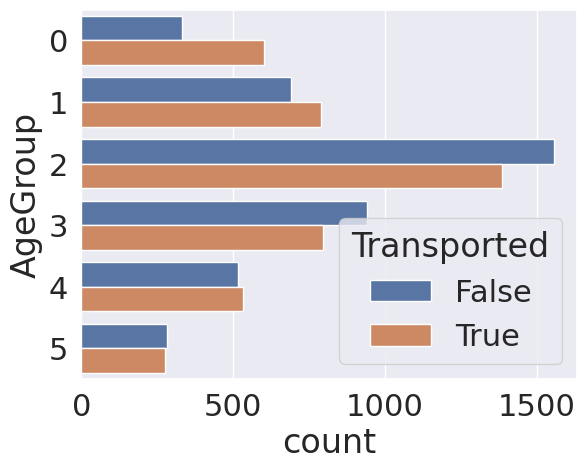

In [26]:
sns.countplot(y=df_train['AgeGroup'], hue=df_train['Transported']) if VISUALIZING else None

## 6.B drop target

In [27]:
df_train['Transported'] = df_train['Transported'].replace({True:1,False:0})

# 6. Pre processing

In [28]:
if DEBUG:
    df_train, df_test = train_test_split(df_train, test_size=0.25, random_state=42)
    y_test = df_test["Transported"]

X_test = df_test.drop(columns=["Transported"]) if DEBUG else df_test

X_train, y_train = (
    df_train.drop(columns=["Transported"]),
    df_train["Transported"],
)

## 6.A Encoding

In [29]:
numeric_feats = [
    "total_spent",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
]
log_numeric_feats = [
    "Cabin_Num",
]
ordinal_feats = [
    "AgeGroup",
]
categorical_feats = [
    "HomePlanet",
    "Destination",
    "Deck",
]
binary_feats = [
    "VIP",
    "CryoSleep",
    "Side",    
]
drop_feats = [
    "Cabin",
    "Name",
    "Age",
]

In [30]:
ct = make_column_transformer(
    (RobustScaler(), numeric_feats),
    (
        make_pipeline(
            PowerTransformer(),
            RobustScaler()
        ),
        log_numeric_feats
    ),
    (OneHotEncoder(), categorical_feats),
    (OrdinalEncoder(), binary_feats),
    (OrdinalEncoder(), ordinal_feats),
    ("drop", drop_feats),
)

In [31]:
ct if VISUALIZING else None

,transformers,"[('robustscaler', ...), ('pipeline', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,with_centering,True
,with_scaling,True
,quantile_range,"(25.0, ...)"


In [32]:
transformed = ct.fit_transform(X_train)

In [33]:
column_names = ct.get_feature_names_out()
clean_names = [name.split("__", 1)[-1] for name in column_names]

transformed = pd.DataFrame(transformed, columns=clean_names)

In [34]:
pd.DataFrame(transformed).head() if VISUALIZING else None

,total_spent,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Num,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,VIP,CryoSleep,Side,AgeGroup
0,-0.496877,0.000000,0.000000,0.000000,0.000000,0.000,-1.334264,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,0.013879,2.658537,0.147541,1.136364,10.358491,1.100,-1.334264,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0
2,6.708536,1.048780,58.622951,0.000000,126.698113,1.225,-1.334264,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,5.0
3,3.095073,0.000000,21.032787,16.863636,62.811321,4.825,-1.334264,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
4,0.260236,7.390244,1.147541,6.863636,10.660377,0.050,-1.284269,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


## 6.B Heatmap

<Axes: >

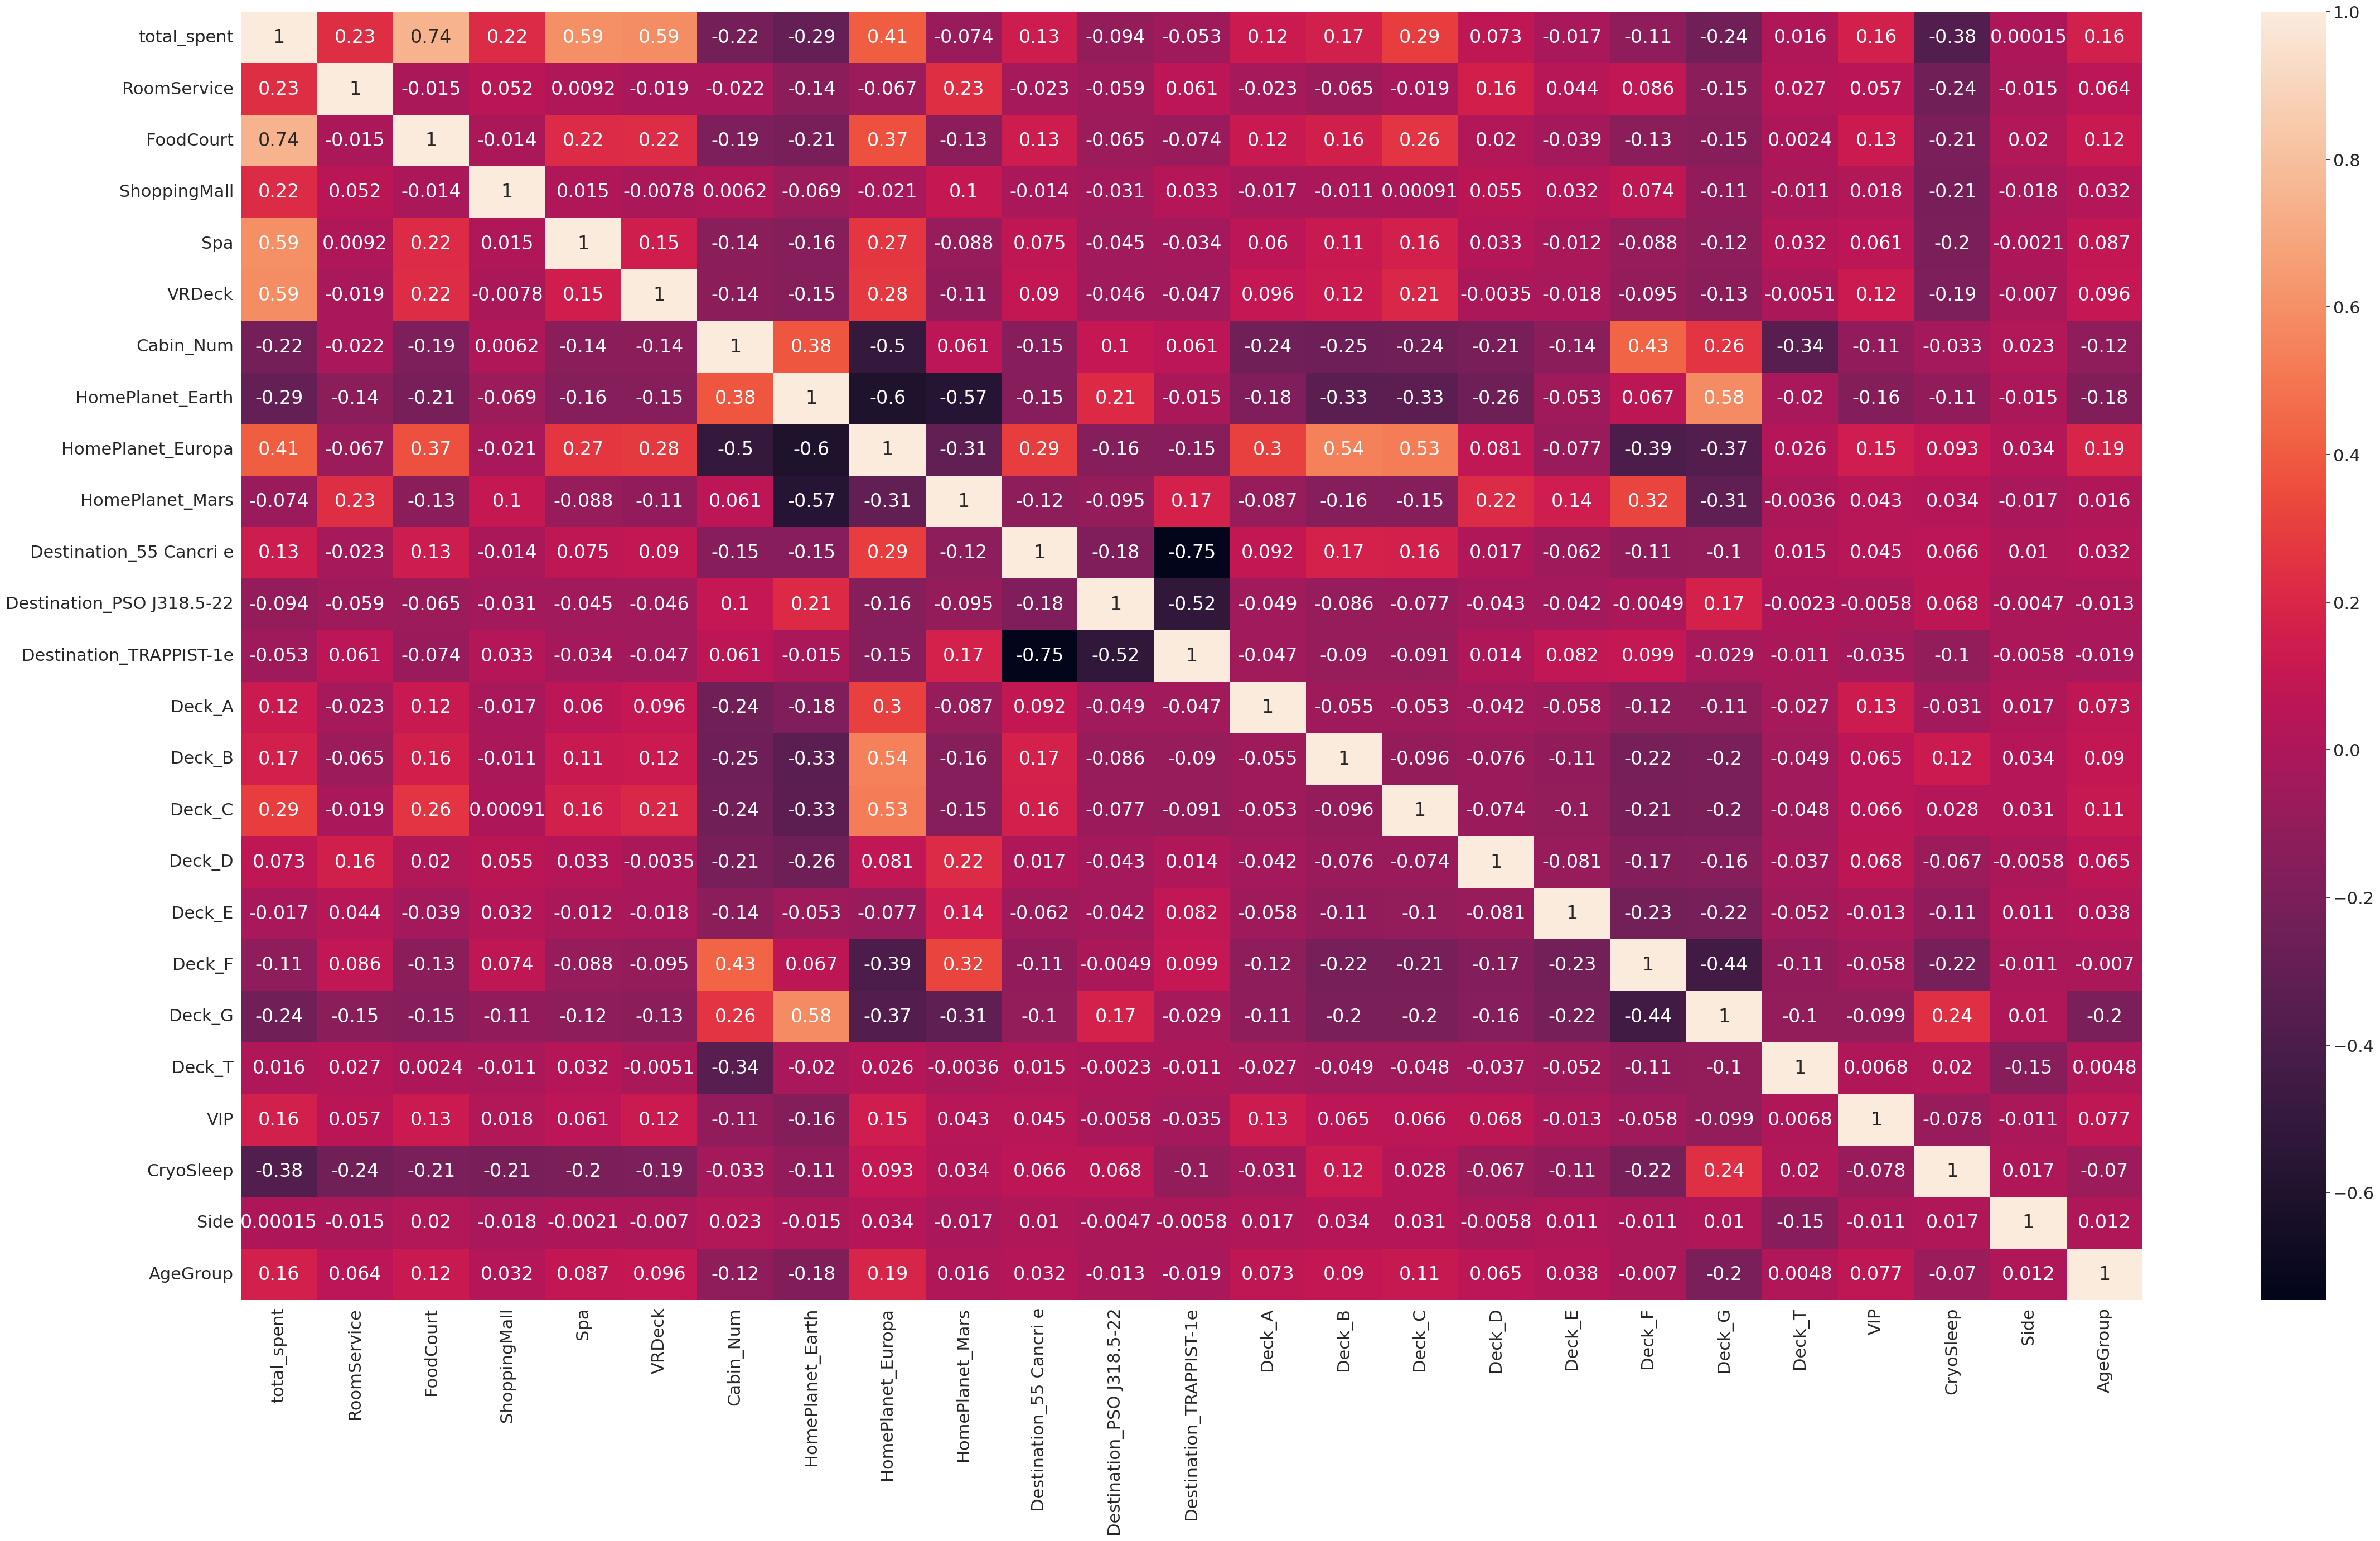

In [35]:
plt.figure(figsize=(55,30)) if VISUALIZING else None
sns.heatmap(transformed.corr(), annot=True) if VISUALIZING else None

# 7. Models

In [43]:
supervised_models = {}
unsupervised_models = {}

## 7.A SVM

### Linear Kernel

In [44]:
grid_search = GridSearchCV(
    estimator=make_pipeline(ct, SVC(kernel='linear')),
    param_grid={
        'svc__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'svc__max_iter': [500, 1000],
    },
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

grid_search.fit(X_train, y_train) if COMPARING_MODELS else None
pd.DataFrame(list(grid_search.best_params_.items()), columns=['Hyperparameter', 'Best Value']) if COMPARING_MODELS else None

In [45]:
svm_linear_model = make_pipeline(ct, SVC(C=1, max_iter=1000)).fit(X_train, y_train)
svm_linear_model if VISUALIZING else None

,steps,"[('columntransformer', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('robustscaler', ...), ('pipeline', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [46]:
y_pred = svm_linear_model.predict(X_test)

In [47]:
accuracy_score(y_test, y_pred) if DEBUG else None

In [48]:
sub = pd.DataFrame({'Transported':y_pred.astype(bool)}, index=df_test.index)
sub.head() if VISUALIZING else None

,Transported
PassengerId,
0013_01,True
0018_01,True
0019_01,True
0021_01,True
0023_01,True


In [49]:
sub.to_csv("../predictions/svm_linear_optimized.csv")

In [50]:
supervised_models["svm_linear"] = svm_linear_model

### RBF Kernel

In [51]:
grid_search = GridSearchCV(
    estimator=make_pipeline(ct, SVC(kernel='rbf')),
    param_grid={
        'svc__C': [0.01, 0.1, 1, 10, 100, 1000],
        'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]
    },
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, y_train) if COMPARING_MODELS else None
pd.DataFrame(list(grid_search.best_params_.items()), columns=['Hyperparameter', 'Best Value']) if COMPARING_MODELS else None

In [52]:
svm_rbf_model = make_pipeline(ct, SVC(C=100, gamma=0.0001)).fit(X_train, y_train)
svm_rbf_model if VISUALIZING else None

,steps,"[('columntransformer', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('robustscaler', ...), ('pipeline', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [53]:
y_pred = svm_rbf_model.predict(X_test)

In [54]:
accuracy_score(y_test, y_pred) if DEBUG else None

In [55]:
sub = pd.DataFrame({'Transported':y_pred.astype(bool)}, index=df_test.index)
sub.head() if VISUALIZING else None

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True


In [56]:
sub.to_csv("../predictions/svm_rbf_optimized.csv")

In [57]:
supervised_models["svm_RBF"] = svm_rbf_model

## 7.B KNN Classifier

In [58]:
grid_search = GridSearchCV(
    estimator=make_pipeline(ct, KNeighborsClassifier()),
    param_grid={
        "kneighborsclassifier__n_neighbors": [1, 3, 5, 7, 9, 11, 15, 21, 25],
        "kneighborsclassifier__weights": ["uniform", "distance"],
        "kneighborsclassifier__metric": ["euclidean", "manhattan"]
    },
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

grid_search.fit(X_train, y_train) if COMPARING_MODELS else None
pd.DataFrame(list(grid_search.best_params_.items()), columns=['Hyperparameter', 'Best Value']) if COMPARING_MODELS else None

In [59]:
knn_model = make_pipeline(ct, KNeighborsClassifier(metric='euclidean', n_neighbors=25, weights='uniform')).fit(X_train, y_train)
knn_model if VISUALIZING else None

,steps,"[('columntransformer', ...), ('kneighborsclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('robustscaler', ...), ('pipeline', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [60]:
y_pred = knn_model.predict(X_test)

In [61]:
accuracy_score(y_test, y_pred) if DEBUG else None

In [62]:
sub = pd.DataFrame({'Transported':y_pred.astype(bool)}, index=df_test.index)
sub.head() if VISUALIZING else None

,Transported
PassengerId,
0013_01,False
0018_01,False
0019_01,True
0021_01,True
0023_01,False


In [63]:
sub.to_csv("../predictions/knn.csv")

In [64]:
supervised_models["kNN"] = knn_model

## 7.C Logistic Regression 

In [65]:
grid_search = GridSearchCV(
    estimator=make_pipeline(ct, LogisticRegression()),
    param_grid={
        "logisticregression__penalty": ["l1", "l2"],
        "logisticregression__solver": ["liblinear", "lbfgs"],
        "logisticregression__C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
        "logisticregression__max_iter": [1000],
    },
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, y_train) if COMPARING_MODELS else None
pd.DataFrame(list(grid_search.best_params_.items()), columns=['Hyperparameter', 'Best Value']) if COMPARING_MODELS else None

In [66]:
logreg_model = make_pipeline(ct, LogisticRegression(C=0.1, max_iter=1000, penalty='l2', solver='lbfgs')).fit(X_train, y_train)
logreg_model if VISUALIZING else None

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('robustscaler', ...), ('pipeline', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [67]:
y_pred = logreg_model.predict(X_test)

In [68]:
accuracy_score(y_test, y_pred) if DEBUG else None

In [69]:
sub = pd.DataFrame({'Transported':y_pred.astype(bool)}, index=df_test.index)
sub.head() if VISUALIZING else None

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True


In [70]:
sub.to_csv("../predictions/logistic_reg.csv")

In [71]:
supervised_models["logistic_regression"] = logreg_model 

## 7.D kMeans

In [72]:
def evaluate_kmeans(X, ks=range(2, 11)):
    silhouettes = []
    inertias = []

    for k in ks:
        km = KMeans(n_clusters=k, init="k-means++", n_init=20)
        labels = km.fit_predict(X)
        silhouettes.append(silhouette_score(X, labels))
        inertias.append(km.inertia_)
    
    return np.array(silhouettes), np.array(inertias)

In [73]:
X_train_kmeans = pd.DataFrame(ct.transform(X_train), columns=clean_names)
X_test_kmeans = pd.DataFrame(ct.transform(X_test), columns=clean_names)

In [74]:
if COMPARING_MODELS: 
    sil, ine = evaluate_kmeans(X_train_kmeans)
    
    ks = range(2, 11)
    
    plt.figure(figsize=(18,6))
    
    plt.subplot(1,2,1)
    plt.plot(ks, ine, marker="o")
    plt.title("Elbow Method (Inertia)")
    plt.xlabel("k")
    plt.ylabel("Inertia")
    
    plt.subplot(1,2,2)
    plt.plot(ks, sil, marker="o")
    plt.title("Silhouette Scores")
    plt.xlabel("k")
    plt.ylabel("Silhouette")

plt.show() if COMPARING_MODELS else None

In [75]:
kmeans = KMeans(n_clusters=2, init="k-means++", n_init=20)
kmeans.fit(transformed)

X_train_kmeans['Cluster'] = kmeans.predict(X_train_kmeans)
X_test_kmeans['Cluster'] = kmeans.predict(X_test_kmeans)

In [76]:
grid_search = GridSearchCV(
    estimator=SVC(kernel='rbf'),
    param_grid={
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [0.0001, 0.001, 0.01, 0.1, 1]
    },
    cv=2,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train_kmeans, y_train) if COMPARING_MODELS else None
pd.DataFrame(list(grid_search.best_params_.items()), columns=['Hyperparameter', 'Best Value']) if COMPARING_MODELS else None

In [77]:
svc_model = SVC(C=100, gamma=0.0001)
svc_model if VISUALIZING else None

,C,100
,kernel,'rbf'
,degree,3
,gamma,0.0001
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [78]:
svc_model.fit(X_train_kmeans, y_train)
y_pred = svc_model.predict(X_test_kmeans)

In [79]:
accuracy_score(y_test, y_pred) if DEBUG else None

In [80]:
sub = pd.DataFrame({'Transported':y_pred.astype(bool)}, index=df_test.index)
sub.head() if VISUALIZING else None

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True


In [81]:
sub.to_csv("../predictions/kmeans.csv")

In [82]:
unsupervised_models["kmeans"] = (svc_model, X_train_kmeans)

## 7.E DBSCAN

In [83]:
def optimize_dbscan_to_df(
    X,
    min_samples_candidates=None,
    eps_percentiles=[50, 75, 90],
    n_eps=20,
    top_n=5,
):
    X = StandardScaler().fit_transform(X)
    dim = X.shape[1]

    if min_samples_candidates is None:
        min_samples_candidates = sorted(list(set([3, 5, 10, dim + 1])))

    results = []
    detailed = []  # includes labels

    for min_s in min_samples_candidates:
        nbrs = NearestNeighbors(n_neighbors=min_s).fit(X)
        distances, _ = nbrs.kneighbors(X)
        k_dist = np.sort(distances[:, -1])

        eps_vals = np.percentile(k_dist, eps_percentiles)
        low, high = eps_vals[0], eps_vals[-1]
        eps_grid = np.linspace(max(1e-6, low * 0.5), high * 1.5, n_eps)

        for eps in eps_grid:
            model = DBSCAN(eps=eps, min_samples=min_s)
            labels = model.fit_predict(X)

            mask = labels != -1
            unique_clusters = np.unique(labels[mask])

            if len(unique_clusters) < 2:
                score = -np.inf
            else:
                try:
                    score = silhouette_score(X[mask], labels[mask])
                except:
                    score = -np.inf

            meta = {
                "eps": eps,
                "min_samples": min_s,
                "score": score,
                "n_clusters": len(unique_clusters),
                "noise_frac": 1 - np.mean(mask),
            }

            results.append(meta)
            detailed.append({**meta, "labels": labels})

    # Sort by score
    results_sorted = sorted(detailed, key=lambda x: x["score"], reverse=True)

    # Build DataFrame of top-N
    df = pd.DataFrame([{k: v for k, v in r.items() if k != "labels"}
                       for r in results_sorted[:top_n]])

    return df, results_sorted[:top_n]

In [84]:
X_train_DBS = pd.DataFrame(ct.transform(X_train), columns=clean_names)
X_test_DBS = pd.DataFrame(ct.transform(X_test), columns=clean_names)

In [85]:
df, full_results = optimize_dbscan_to_df(X_train_DBS) if COMPARING_MODELS else None, None
df if COMPARING_MODELS else None

In [86]:
dbscan = DBSCAN(eps=0.268023, min_samples=3)
dbscan if VISUALIZING else None

,eps,0.268023
,min_samples,3
,metric,'euclidean'
,metric_params,None
,algorithm,'auto'
,leaf_size,30
,p,None
,n_jobs,None


In [87]:
dbscan.fit(X_train_DBS)
dbscan_train_labels = dbscan.labels_

In [88]:
# use knn to predict which cluster to be in
cluster_predictor = KNeighborsClassifier(n_neighbors=10)
cluster_predictor.fit(X_train_DBS, dbscan_train_labels)
dbscan_test_labels = cluster_predictor.predict(X_test_DBS)

In [89]:
# make augmented dataframe - original data + cluster predicted
X_train_augmented = X_train_DBS.copy()
X_train_augmented['DBSCAN_Cluster'] = dbscan_train_labels

X_test_augmented = X_test_DBS.copy()
X_test_augmented['DBSCAN_Cluster'] = dbscan_test_labels

In [90]:
grid_search = GridSearchCV(
    estimator=SVC(kernel='rbf'),
    param_grid={
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [0.0001, 0.001, 0.01, 0.1, 1]
    },
    cv=2,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train_augmented, y_train) if COMPARING_MODELS else None
pd.DataFrame(list(grid_search.best_params_.items()), columns=['Hyperparameter', 'Best Value']) if COMPARING_MODELS else None

In [91]:
svc_DBS = SVC(C=100, gamma=0.0001)
svc_DBS if VISUALIZING else None

,C,100
,kernel,'rbf'
,degree,3
,gamma,0.0001
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [92]:
svc_DBS.fit(X_train_augmented, y_train)
y_pred = svc_DBS.predict(X_test_augmented)

In [93]:
accuracy_score(y_test, y_pred) if DEBUG else None

In [94]:
sub = pd.DataFrame({'Transported':y_pred.astype(bool)}, index=df_test.index)
sub.head() if VISUALIZING else None

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True


In [95]:
sub.to_csv("../predictions/dbscan.csv")

In [96]:
unsupervised_models["dbscan"] = (svc_DBS, X_train_augmented)

## 7.E RandomForestClassifier

In [97]:
search = RandomizedSearchCV(
    estimator=make_pipeline(ct, RandomForestClassifier()),
    param_distributions ={
        "randomforestclassifier__n_estimators": [200, 400, 800],
        "randomforestclassifier__max_depth": [None, 10, 30],
        "randomforestclassifier__min_samples_split": [2, 10],
        "randomforestclassifier__min_samples_leaf": [1, 4],
        "randomforestclassifier__max_features": ["sqrt", "log2"],
    },
    cv=3,
    scoring='roc_auc',
    n_iter=50,
    n_jobs=-1
)

search.fit(X_train, y_train) if COMPARING_MODELS else None
pd.DataFrame(list(search.best_params_.items()), columns=['Hyperparameter', 'Best Value']) if COMPARING_MODELS else None

In [98]:
random_forest_model = make_pipeline(ct, RandomForestClassifier(n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features='sqrt', max_depth=30)).fit(X_train, y_train)
random_forest_model if VISUALIZING else None

,steps,"[('columntransformer', ...), ('randomforestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('robustscaler', ...), ('pipeline', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [99]:
y_pred = random_forest_model.predict(X_test)

In [100]:
accuracy_score(y_test, y_pred) if DEBUG else None

In [101]:
sub = pd.DataFrame({'Transported':y_pred.astype(bool)}, index=df_test.index)
sub.head() if VISUALIZING else None

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True


In [102]:
sub.to_csv("../predictions/random_forest.csv")

In [103]:
supervised_models["random_forest"] = random_forest_model

## 7.F GradientBoostingClassifier

In [104]:
search = RandomizedSearchCV(
    estimator=make_pipeline(ct, GradientBoostingClassifier()),
    param_distributions ={
        "gradientboostingclassifier__n_estimators": [100, 200, 300],
        "gradientboostingclassifier__learning_rate": [0.01, 0.05, 0.1],
        "gradientboostingclassifier__max_depth": [2, 3, 4],
        "gradientboostingclassifier__subsample": [0.7, 1.0],
        "gradientboostingclassifier__max_features": ["sqrt", "log2"],
    },
    cv=5,
    scoring='roc_auc',
    n_iter=50,
    n_jobs=-1
)

search.fit(X_train, y_train) if COMPARING_MODELS else None
pd.DataFrame(list(search.best_params_.items()), columns=['Hyperparameter', 'Best Value']) if COMPARING_MODELS else None

In [105]:
gradient_boost_model = make_pipeline(ct, GradientBoostingClassifier(subsample=0.7, n_estimators=300, max_features='sqrt', max_depth=4, learning_rate=0.05)).fit(X_train, y_train)
gradient_boost_model if VISUALIZING else None

,steps,"[('columntransformer', ...), ('gradientboostingclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('robustscaler', ...), ('pipeline', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [106]:
y_pred = gradient_boost_model.predict(X_test)

In [107]:
accuracy_score(y_test, y_pred) if DEBUG else None

In [108]:
sub = pd.DataFrame({'Transported':y_pred.astype(bool)}, index=df_test.index)
sub.head() if VISUALIZING else None

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True


In [109]:
sub.to_csv("../predictions/gradient_boost.csv")

In [110]:
supervised_models["gradient_boost"] = gradient_boost_model

## 7.G Voting Classifier

### 7.G.1 Setup

In [112]:
estimators = []
for name, model in supervised_models.items():
    estimators.append((name, model))

In [114]:
estimators = []
for name, model in supervised_models.items():
    pipe = make_pipeline(ct, model)
    estimators.append((name, pipe))

### 7.G.2 Soft Voting

In [115]:
soft_voting_model = VotingClassifier(estimators, voting='soft')
soft_voting_model.fit(X_train, y_train)

ValueError: Specifying the columns using strings is only supported for dataframes.

In [116]:
y_pred = soft_voting_model.predict(X_test)
accuracy_score(y_test, y_pred) if DEBUG else None

AttributeError: 'VotingClassifier' object has no attribute 'estimators_'

In [117]:
sub = pd.DataFrame({'Transported': y_pred.astype(bool)}, index=df_test.index)
sub.to_csv("../predictions/soft_voting_classifier.csv")

### 7.G.3 Hard Voting

In [118]:
hard_voting_model = VotingClassifier(estimators, voting='hard')
hard_voting_model.fit(X_train, y_train)

ValueError: Specifying the columns using strings is only supported for dataframes.

In [119]:
y_pred = hard_voting_model.predict(X_test)
accuracy_score(y_test, y_pred) if DEBUG else None

AttributeError: 'VotingClassifier' object has no attribute 'estimators_'

In [120]:
soft_voting_model = VotingClassifier(estimators, voting='soft')
soft_voting_model.fit(X_train, y_train)
y_pred = soft_voting_model.predict(X_test)
accuracy_score(y_test, y_pred)

ValueError: Specifying the columns using strings is only supported for dataframes.

In [121]:
sub = pd.DataFrame({'Transported': y_pred.astype(bool)}, index=df_test.index)
sub.to_csv("../predictions/hard_voting_classifier.csv")

# 8. Comparing Models

In [124]:
results = {}
for name, model in supervised_models.items():
    scores = cross_validate(
        model, 
        X_train, 
        y_train,
        cv=5, 
        scoring="accuracy",
        n_jobs=-1,
        return_train_score=True
    ) if VISUALIZING else None
    results[name] = pd.DataFrame(scores).mean() if VISUALIZING else None

scores = cross_validate(
    svc_model, 
    X_train_kmeans,
    y_train,
    cv=5, 
    scoring="accuracy",
    n_jobs=-1,
    return_train_score=True
) if VISUALIZING else None
results["kmeans"] = pd.DataFrame(scores).mean() if VISUALIZING else None

scores = cross_validate(
    svc_DBS, 
    X_train_augmented,
    y_train,
    cv=5, 
    scoring="accuracy",
    n_jobs=-1,
    return_train_score=True
) if VISUALIZING else None
results["dbscan"] = pd.DataFrame(scores).mean() if VISUALIZING else None

,svm_linear,svm_RBF,kNN,logistic_regression,random_forest,gradient_boost,kmeans,dbscan
fit_time,0.729590,1.684791,0.035655,0.140971,4.634760,1.125203,1.804288,1.927339
score_time,0.202400,0.308782,0.104827,0.007730,0.129765,0.015848,0.309899,0.283304
test_score,0.605436,0.790409,0.795816,0.784655,0.789605,0.787880,0.791214,0.792479
train_score,0.610174,0.796618,0.808841,0.793685,0.888358,0.846313,0.796906,0.798372


In [125]:
results_df = pd.DataFrame(results)
results_df = results_df.T.drop(columns=['fit_time', 'score_time']).T

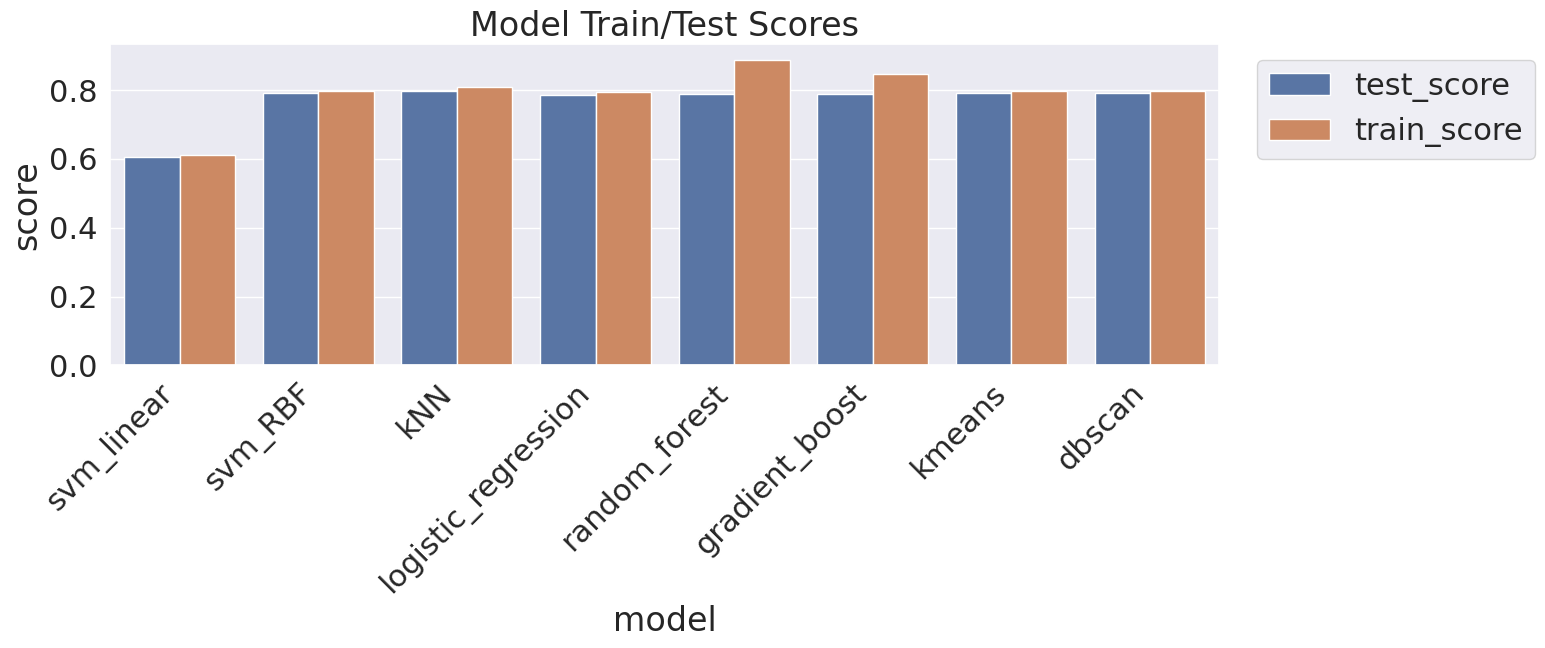

In [126]:
df_long = results_df.reset_index().melt(id_vars="index", var_name="model", value_name="score")

df_long = df_long.rename(columns={"index": "metric"})

plt.figure(figsize=(16, 7))
sns.barplot(data=df_long, x="model", y="score", hue="metric")
plt.xticks(rotation=45, ha="right")
plt.title("Model Train/Test Scores")
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show() if VISUALIZING else None